# Transformer가 나오기까지

어텐션(Attention) 기법을 간단히 복습한 후, 이를 활용한 트랜스포머(Transformer)에 포함된 모듈을 심층적으로 이해한다. 트랜스포머를 발전시키기 위해 적용된 테크닉도 간략히 알아본다.


- 들어가며
- Attention의 역사
- Attention Is All You Need!
- Positional Encoding
- Multi-Head Attention
- Position-wise Feed-Forward Networks
- Additional Techniques
- 트랜스포머, 그 후엔..
- 마지막

# 들어가며

모든 내용을 완벽히 이해하시길 ...

# Attention의 역사

[seq2seq 복습](https://wikidocs.net/24996)

[Bahdanau Attention 복습](https://eda-ai-lab.tistory.com/157) - [원문](https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3)

[Luong Attention 복습](https://hcnoh.github.io/2019-01-01-luong-attention)

# [Attention Is All You Need!](https://arxiv.org/pdf/1706.03762.pdf)

RNN(기울기 소실 문제)과 CNN 버리자!

논문의 핵심 부분을 나눠서 설명할 예정

# [Positional Encoding](https://skyjwoo.tistory.com/31)

## 문장에 연속성을 어떻게 부여할 것인가?

|일정한 범위|일정한 증가|
|:-:|:-:|
|0, 0.5, 1|0, 1, 2|
|0, 0.01, ... , 0.99, 1|0, 1, ..., 99, 100|
|단어 간의 거리가 일정하지 않음|값이 매우 커질 수 있음|

## 논문에서 생각하는 방법은 무엇인가?

Positional Encoding == Sinusoid Embedding

$$PE_{(pos, 2i)}=sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)}=cos(pos/10000^{2i/d_{model}})$$

![https://www.researchgate.net/figure/Visualization-of-the-positional-encoding_fig2_346516047](https://www.researchgate.net/publication/346516047/figure/fig2/AS:963822751866897@1606804659871/Visualization-of-the-positional-encoding.png)

Positional Embedding

![https://velog.io/@crosstar1228/NLPTransformer-Attention-is-all-you-need-%EC%83%85%EC%83%85%EC%9D%B4-%ED%8C%8C%ED%97%A4%EC%B9%98%EA%B8%B0](https://velog.velcdn.com/images%2Fcrosstar1228%2Fpost%2F68fb22d6-71a4-4bd5-81b3-8037acbeb160%2Fimage.png)

Embedding의 경우 학습에 과정이 필요!


In [3]:
import numpy as np

def positional_encoding(pos, d_model):
  def cal_angle(position, i):
    return position / np.power(10000, int(i) / d_model)

  def get_posi_angle_vec(position):
    return [cal_angle(position, i) for i in range(d_model)]

  sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

  return sinusoid_table

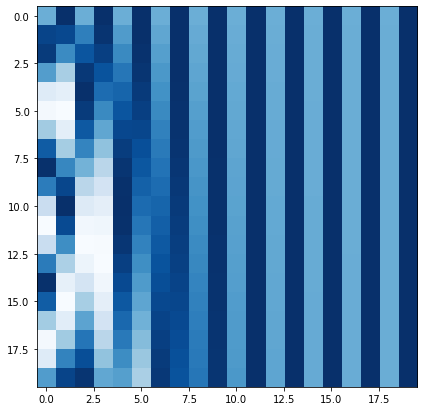

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.imshow(positional_encoding(20, 20), cmap='Blues')
plt.show()

# [Multi-Head Attention](https://reniew.github.io/43/)

![https://wikidocs.net/162098](https://wikidocs.net/images/page/159310/mha_img_original.png)

\+ 인과 관계 마스킹(Causality Masking)

## Scaled Dot-Product Attention

- MatMul(Q, K)
  - 유사도 분석
- Scale
  - 값이 커지는 것을 방지함
- Mask(opt)
  - 

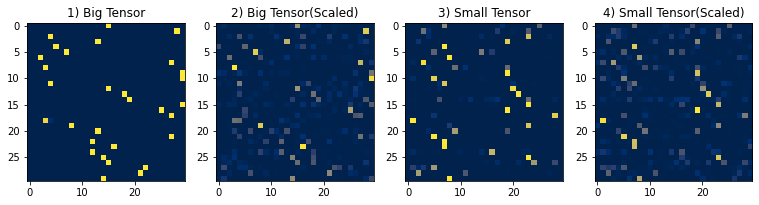

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
  A = tf.random.uniform(shape, minval=-3, maxval=3)
  B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])
  return tf.tensordot(A, B, axes=1)

length = 30
big_dim = 1024.
small_dim = 10.

big_tensor = make_dot_product_tensor((length, int(big_dim)))
scaled_big_tensor = big_tensor / tf.sqrt(big_dim)
small_tensor = make_dot_product_tensor((length, int(small_dim)))
scaled_small_tensor = small_tensor / tf.sqrt(small_dim)

fig = plt.figure(figsize=(13, 6))

axs = []
titles = [
  '1) Big Tensor',
  '2) Big Tensor(Scaled)',
  '3) Small Tensor',
  '4) Small Tensor(Scaled)'
]

datas = [
  big_tensor,
  scaled_big_tensor,
  small_tensor,
  scaled_small_tensor
]

for i in range(4):
  axs.append(fig.add_subplot(1,4,i + 1))
  axs[-1].set_title(titles[i])
  axs[-1].imshow(tf.nn.softmax(datas[i], axis=-1).numpy(), cmap='cividis')

plt.show()

선명한 값을 나타낼수록 모델이 단순화 함

즉, scaled 한 것이 더 좋음

## 인과 관계 마스킹(Causality Masking)

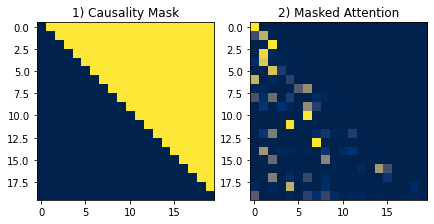

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

def generate_causality_mask(seq_len):
    mask = 1 - np.cumsum(np.eye(seq_len, seq_len), 0)
    return mask

sample_tensor = make_dot_product_tensor((20, 512))
sample_tensor = sample_tensor / tf.sqrt(512.)

mask = generate_causality_mask(sample_tensor.shape[0])

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('1) Causality Mask')
ax2.set_title('2) Masked Attention')

ax1.imshow((tf.ones(sample_tensor.shape) + mask).numpy(), cmap='cividis')

mask *= -1e9
ax2.imshow(tf.nn.softmax(sample_tensor + mask, axis=-1).numpy(), cmap='cividis')

plt.show()

마스킹된 값은 softmax에서 0이 될 것임으로, 역전파 값이 0이 됨

![https://peterbloem.nl/blog/transformers](https://peterbloem.nl/files/transformers/masked-attention.svg)

현재 정보에 미래 정보가 들어가지 않음

## Multi-Head Attention

![https://www.youtube.com/watch?v=mMa2PmYJlCo](https://i.ytimg.com/vi/mMa2PmYJlCo/maxresdefault.jpg)

각 정보가 알맞게 모여있을 가능성을 확보하기 위해, Linear 함수를 거침

위와 동일한 이유로 출력값을 concat한 후, Linear를 통과함

# Position-wise Feed-Forward Networks

![https://www.kdnuggets.com/2020/10/understanding-transformers-data-science-way.html](https://miro.medium.com/max/1906/1*1l5JbeGfEGh2oxjI8koHdQ.png)

다른 방법으로는 conv로 볼 수 있음

![](https://d3s0tskafalll9.cloudfront.net/media/images/GN-5-L_1dconv.max-800x600.png)

# Additional Techniques

## Layer Normalization